EE838

PA1 Problem2: `Automatic Homography using RANSAC`

Jedsadakorn Yonchorhor 20194695

In [1]:
''' Import important libs '''
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt

print(cv2.__version__)

4.4.0


In [2]:
''' Prepare the data '''

# read images
img = list()
filepaths = ["dorm_left.jpg", "dorm_center.jpg", "dorm_right.jpg"]
num_img = len(filepaths)
for path in filepaths:
    img.append(cv2.imread(path))


# prepared the images for the output
# because usually it's bigger than it's size
ty, tx = img[0].shape[:2]
translation_M = np.float32([[1, 0, tx], [0, 1, ty/2]])
translated_img = list()
for i in range(3):
    dst = cv2.warpAffine(img[i], translation_M, (tx*3, ty * 2))
    translated_img.append(dst)

In [3]:
''' get features and descriptors for all the images '''

# compute interest points
# Initiate ORB detector
orb = cv2.ORB_create()
keypoints = list()
descriptors = list()
for i in range(num_img):
    # find the keypoints with ORB and compute the descriptors with ORB
    kp, des = orb.detectAndCompute(img[i], None)
    keypoints.append(kp)
    descriptors.append(des)

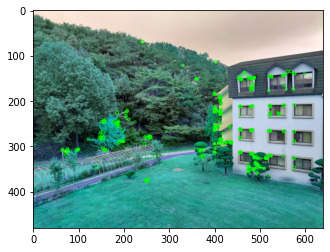

True

In [4]:
img2 = cv2.drawKeypoints(img[0], keypoints[0], None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()
cv2.imwrite("dorm_left_kpts.jpg", img2)

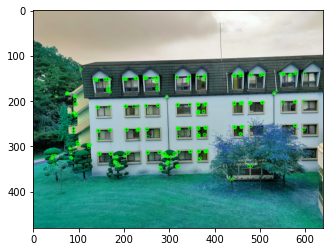

True

In [5]:
img2 = cv2.drawKeypoints(img[1], keypoints[1], None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()
cv2.imwrite("dorm_center_kpts.jpg", img2)

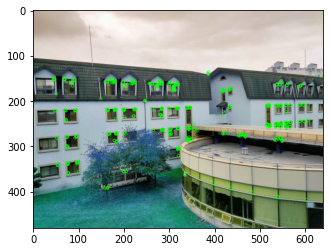

True

In [6]:
img2 = cv2.drawKeypoints(img[2], keypoints[2], None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()
cv2.imwrite("dorm_right_kpts.jpg", img2)

In [7]:
def compute_putative_correspondence(descriptor1, descriptor2):
    '''
        Find the matching features from each image using its descriptor

        parameters
            - descriptors: (list)
                descriptor of the features in each image
        return
            - match_id: (list) of shape len(descriptor1)
                each element is the value of (SSD, idx_des1, idx_des2)
    '''
    match_id = list()
    num_descriptor1 = len(descriptor1)
    for i in range(num_descriptor1):
        # SSD: Sum of Square Difference
        diff = np.square(descriptor2 - descriptor1[i])
        sum_of_diff = np.sum(diff, 1)

        # assign the minimum to the match
        idx = np.argmin(sum_of_diff)
        val = sum_of_diff[idx]

        match_id.append((val, i, idx))

    # sort the matching features from the lowest distance    
    match_id.sort()

    return match_id

def get_correspondence_pairs(keypoints1, keypoints2, match_id):
    '''
        Extract the corresponding keypoint pairs

        parameters
            - keypoints: (list)
                keypoints of each images
            - match_id: (list)
                the idx of the matched pair
        
        return
            - corr_pairs: (list)
                correspond keypoint pairs 
    '''
    num_pairs = len(match_id)
    corr_pairs = [(keypoints1[match_id[i][1]], keypoints2[match_id[i][2]]) for i in range(num_pairs)]
    return corr_pairs

def get_four_correspondence_pairs(corr_pairs):
    '''
        Randomly sample 4 pairs from all of the corresponding pairs

        parameters
            - corr_pairs: (list)
                correspond keypoint pairs 
        
        return
            - four_corr_pairs: (list)
                four of the correspondence pairs
    '''
    corr_pairs = corr_pairs
    four_corr_pairs = list()
    idx_list = np.random.randint(len(corr_pairs), size=4)

    four_corr_pairs = [corr_pairs[i] for i in idx_list]
    
    return four_corr_pairs

In [8]:
def normalize_kpts(kpts):
    '''
        Transform the keypoints to the normalized coordinate

        parameters
            - kpts: (numpy array: #keypoints x len((x, y, 1)))
                keypoints in the image
            
        return
            - X_hat: (numpy array: #keypoints x len((x, y, 1)))
                normalized keypoints: means = 0 and average distance from origin is sqrt(2)
            - T1: (numpy array: 3x3)
                transformation matrix from original coordinate to the normalized coordinate
    '''
    # calculate mean in each axis
    mean = np.mean(kpts, axis=0)

    # calculate Transformation matrix
    # calculate s
    s = math.sqrt(2) / np.mean(np.sqrt(np.sum(np.square(kpts - mean))))

    # calculate tx, ty
    tx = -s*mean[0]
    ty = -s*mean[1]

    # transform to the normalized coordinate
    T1 = np.matrix([[s, 0, tx], 
                    [0, s, ty],
                    [0, 0,  1]])
    X = np.ones((len(kpts), 3))
    X[:, :2] = kpts
    X_hat = (T1 @ X.T).T

    return X_hat, T1

In [9]:
def DLT(X1, X2):
    '''
        DLT algorithm (used only in normalized_DLT() )

        parameters
            - X: (numpy array: #keypoints x len((x, y, 1)))
                Normalized keypoints from each image

        returns
            - H: (numpy array: 3x3)
                Homography matrix in the normalized coordinate
    '''
    num_points = X1.shape[0]
    # one pair gives 2 contraints
    A = np.zeros((num_points * 2, 9))

    # stacking n of 2x9 matrix
    for i in range(num_points):
        # the first constraint
        A[2*i][3: 6] = [-X2[i, 2] * X1[i, 0], -X2[i, 2] * X1[i, 1], -X2[i, 2] * X1[i, 2]]
        A[2*i][6:]   = [ X2[i, 1] * X1[i, 0],  X2[i, 1] * X1[i, 1],  X2[i, 1] * X1[i, 2]]

        # the second constraint
        A[2*i+1][:3] = [ X2[i, 2] * X1[i, 0],  X2[i, 2] * X1[i, 1],  X2[i, 2] * X1[i, 2]]
        A[2*i+1][6:] = [-X2[i, 0] * X1[i, 0], -X2[i, 0] * X1[i, 1], -X2[i, 0] * X1[i, 2]]
    
    u, s, vh = np.linalg.svd(A)
    
    H = vh[-1] # Homography is the column of matrix v associated with the smallest singular value
    if H[-1] != 0:
        H = H / H[-1]
    else:
        print("Warning: h9 = 0")
        return None
        
    return H.reshape(3, 3)

In [10]:
def normalized_DLT(corr_pairs):
    """
        normalized DLT algorithm: calculate Homography between two images

        parameters
            - corr_pairs: (list)
                correspond keypoint pairs 

        returns
            - H: (numpy array: 3x3)
                Homography matrix in the original coordinate
    """

    num_pairs = len(corr_pairs)
    X1 = np.empty((num_pairs, 2))
    X2 = np.empty((num_pairs, 2))

    # unpacking the Keypoints
    for i in range(num_pairs):
        X1[i] = corr_pairs[i][0].pt
        X2[i] = corr_pairs[i][1].pt

    X1_hat, T1 = normalize_kpts(X1)
    X2_hat, T2 = normalize_kpts(X2)

    # homography in normalized coordinate
    H_hat = DLT(X1_hat, X2_hat)

    # homography in the original coordinate
    H = np.linalg.inv(T2) @ H_hat @ T1
    H = H / H[-1, -1]       # normalize h9

    return H

In [11]:
def get_euclidean_distance(pts1, pts2):
    '''
        calculate euclidean distance between the set of corresponding pairs

        parameters
            - pts: (numpy array: #keypoints x len((x, y, 1)))
                keypoints in the image 
                keypoints in pts1 should be the pair of pts2

        returns
            - array of the euclidean distance of each pair
    '''
    return np.sqrt(np.sum(np.square(pts1 - pts2), axis=1))

def compute_distance_and_std(corr_pairs, H):
    '''
        calculate the distance between the keypoints and their projection, 
        also the standard deviation of the distance 

        parameters
            - corr_pairs: (list)
                correspond keypoint pairs 
            - H: (numpy array: 3x3)
                homography matrix
        
        returns
            - curr_diss: (float)
            - curr_std: (float)

    '''
    num_pairs = len(corr_pairs)
    X1 = np.ones((num_pairs, 3))
    X2 = np.ones((num_pairs, 3))

    # unpacking the Keypoints
    for i in range(num_pairs):
        X1[i][:2] = corr_pairs[i][0].pt
        X2[i][:2] = corr_pairs[i][1].pt

    projected_X2 = (np.linalg.inv(H) @ X2.T).T
    projected_X2 = projected_X2 / projected_X2[:, -1].reshape(-1, 1)

    projected_X1 = (H @ X1.T).T
    projected_X1 = projected_X1 / projected_X1[:, -1].reshape(-1, 1)

    curr_dis = get_euclidean_distance(X1, projected_X2) + \
            get_euclidean_distance(X2, projected_X1)
        
    curr_std = np.std(curr_dis)

    return curr_dis, curr_std
  

In [12]:
def count_inliers(curr_dis, th=10):
    '''
        count the number of the inliers and get theirs index

        parameters
            - curr_dis: (numpy array: #corresponding pairs x 1)
                distance of the keypoints and its projection (backward and forward)
            - th: (float)
                threshould to choose the inliers
        
        returns
            - N: (int)
                number of the inlier
            - idx_inliers[0]: (numpy array: #corresponding pairs x 1)
                array of index of the inliers

    '''
    test = curr_dis < th
    idx_inliers = np.where(test==1)
    N = np.sum(test)
    return N, idx_inliers[0]

In [13]:
def is_collinear(four_corr_pairs):
    '''
        Check whether the selected four corresponding pairs are colinear

        parameters
            - four_corr_pairs: (list)
                four of the correspondence pairs
        
        return
            - True or False

    '''
    num_pairs = len(four_corr_pairs)
    X1 = np.ones((num_pairs, 2))
    X2 = np.ones((num_pairs, 2))

    # unpacking the Keypoints
    for i in range(num_pairs):
        X1[i][:2] = corr_pairs[i][0].pt
        X2[i][:2] = corr_pairs[i][1].pt
    
    # all the possible combinations
    test_idx = [(0, 1, 2),
                (0, 1, 3),
                (0, 2, 3),
                (1, 2, 3)]

    # check X1
    for idx in test_idx:
        # check all the combination in both images
        p11 = X1[idx[0]]
        p12 = X1[idx[1]]
        p13 = X1[idx[2]]

        p21 = X2[idx[0]]
        p22 = X2[idx[1]]
        p23 = X2[idx[2]]

        if (collinearity(p11, p12, p13) or collinearity(p21, p22, p23)):
            return True
        
    return False

def collinearity(p0, p1, p2):
    '''
        check whether the three points are colinear
        # ref: https://stackoverflow.com/questions/9608148/python-script-to-determine-if-x-y-coordinates-are-colinear-getting-some-e

        parameters:
            p: (numpy array: 1 x len([x,y]))
                points in the 2D plane

        returns:
            True or False
    ''' 
    
    x1, y1 = p1[0] - p0[0], p1[1] - p0[1]
    x2, y2 = p2[0] - p0[0], p2[1] - p0[1]
    return abs(x1 * y2 - x2 * y1) < 1e-12

In [14]:
def ransac(corr_pairs, N=500, T_DIST=10.0, MAX_inlier=-1, MIN_std=10e5, p=0.99):
    '''
        Robustly calculate the homography between the two images

        parameters:
            - corr_pairs: (list)
                correspond keypoint pairs 
            - N: (int)
                number of the iterlations
            - T_DIST: (float)
                distance threshould to decide the inliers
            - MAX_inliers: (int)
                maximum number of inliers
                the default value -1 means no limit, and it will get updated in the iteration
            - MIN_std: (float)
                minimum of the standard deviation of the keypoint distance, it will get updated in the interation
            - p: (float)
                the probability that we want get the inliers
        
        returns:
            - H: (numpy array: 3x3)
                Homography left

    '''
    n = len(corr_pairs) # number of putative correspondence
    H = None
    idx_inliers = None
    iteration = 0

    
    while N >= iteration:
        four_corr_pairs = get_four_correspondence_pairs(corr_pairs)
        
        if is_collinear(four_corr_pairs):
            continue

        H_curr = normalized_DLT(four_corr_pairs)
        # if H_curr is singular, discard it
        if np.linalg.det(H_curr) == 0:  
            continue

        dis_curr, std_curr = compute_distance_and_std(corr_pairs, H_curr)
        m_curr, idx_inliers_curr = count_inliers(dis_curr, th=T_DIST)

        if m_curr > MAX_inlier or (m_curr == MAX_inlier and std_curr < MIN_std):
            # update the parameters, so that output keeps improving
            MAX_inlier = m_curr
            MIN_std = std_curr
            H = H_curr
            idx_inliers = idx_inliers_curr

            # update the number of iterations
            eps = 1 - m_curr / n
            N = int(math.log(1 - p) / math.log(1 - (1-eps)**4))
            print("The number of inliers = {} and the RANSAC will run for {} more iterlations" .format(m_curr, N))

        iteration += 1
    
    # refinement
    inliers_corr_pairs = [corr_pairs[idx] for idx in idx_inliers]
    H = normalized_DLT(inliers_corr_pairs)  # calculate Homography with inliers only

    return H

In [15]:
''' Find the homography that transform the left image into the center image perspective '''
match_id = compute_putative_correspondence(descriptors[0], descriptors[1])
corr_pairs = get_correspondence_pairs(keypoints[0], keypoints[1], match_id)
H = ransac(corr_pairs)

The number of inliers = 4 and the RANSAC will run for 1124309129 more iterlations
The number of inliers = 13 and the RANSAC will run for 10077485 more iterlations
The number of inliers = 13 and the RANSAC will run for 10077485 more iterlations
The number of inliers = 13 and the RANSAC will run for 10077485 more iterlations
The number of inliers = 15 and the RANSAC will run for 5685392 more iterlations
The number of inliers = 16 and the RANSAC will run for 4391830 more iterlations
The number of inliers = 17 and the RANSAC will run for 3446114 more iterlations
The number of inliers = 18 and the RANSAC will run for 2741797 more iterlations
The number of inliers = 20 and the RANSAC will run for 1798892 more iterlations
The number of inliers = 21 and the RANSAC will run for 1479952 more iterlations
The number of inliers = 24 and the RANSAC will run for 867520 more iterlations
The number of inliers = 50 and the RANSAC will run for 46049 more iterlations
The number of inliers = 157 and the RA

In [25]:
''' Construct the matrix to translate the perspective transformed image '''
ty, tx = img[0].shape[:2]
M = np.float32([[1, 0, tx], [0, 1, ty/2], [0, 0, 1]])

In [47]:
''' Apply homography transformation and also translation '''
maxHeight, maxWidth = translated_img[0].shape[:2]
warp_1 = cv2.warpPerspective(img[0], M.dot(H), (maxWidth, maxHeight))

In [48]:
''' Find the homography that transform the right image into the center image perspective '''
match_id_2 = compute_putative_correspondence(descriptors[2], descriptors[1])
corr_pairs_2 = get_correspondence_pairs(keypoints[2], keypoints[1], match_id_2)
H_2 = ransac(corr_pairs_2)

The number of inliers = 7 and the RANSAC will run for 119876355 more iterlations
The number of inliers = 15 and the RANSAC will run for 5685392 more iterlations
The number of inliers = 27 and the RANSAC will run for 541587 more iterlations
The number of inliers = 30 and the RANSAC will run for 355334 more iterlations
The number of inliers = 48 and the RANSAC will run for 54217 more iterlations
The number of inliers = 93 and the RANSAC will run for 3845 more iterlations
The number of inliers = 130 and the RANSAC will run for 1005 more iterlations


In [49]:
''' Apply homography transformation and also translation '''
warp_2 = cv2.warpPerspective(img[2], M.dot(H_2), (maxWidth, maxHeight))

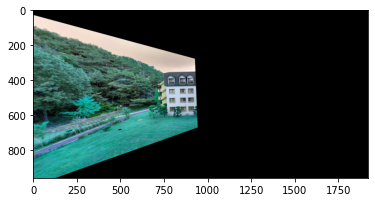

(&lt;matplotlib.image.AxesImage at 0x7fec1a9aa250&gt;, None)

In [50]:
plt.imshow(warp_1), plt.show()  # the homography transformed of the left image

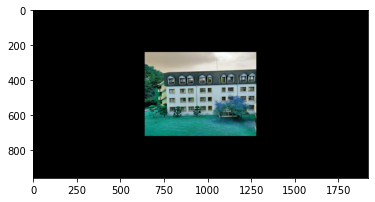

(&lt;matplotlib.image.AxesImage at 0x7fec1a8160d0&gt;, None)

In [51]:
plt.imshow(translated_img[1]), plt.show() # the middle image remain unchanged

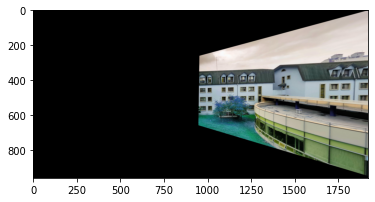

(&lt;matplotlib.image.AxesImage at 0x7fec1aa55790&gt;, None)

In [52]:
plt.imshow(warp_2), plt.show() # the homography transformed of the left image

In [53]:
def stitch_panorama(img_l, img_c, img_r):
    '''
        Put the (transformed version of) left image, center image and right image together and save it

        parameters:
            - img_l: (numpy array h x w x 3) 
                left image
            - img_c: (numpy array h x w x 3)
                center image
            - img_r: (numpy array h x w x 3)
                right image
        return:

    '''

    final_result = np.zeros((maxHeight, maxWidth, 3))
    mask_1 = img_l!=0
    final_result[mask_1] = img_l[mask_1]

    mask_2 = img_r!=0
    final_result[mask_2] = img_r[mask_2]

    mask_3 = img_c!=0
    final_result[mask_3] = img_c[mask_3]
    cv2.imwrite("result.jpg", final_result)
    return final_result

final_image = stitch_panorama(warp_1, translated_img[1], warp_2)

In [54]:
show_final_image = cv2.imread("result.jpg")
cv2.imshow("panorama image", show_final_image)
cv2.waitKey(0)
cv2.destroyAllWindows()